In [1]:

'''
Load the data of the LIGO Hanford detector from [2]. Plot the noise power spectral density (PSD) of that data. Test whether there is any gravitational wave signal present in the data or not? For this test, you can assume the GW signals can produce only from equal mass binary systems with a range between 5 to 10. We assume a threshold on matched filter SNR of 8 to claim detection of GW
'''

'\nLoad the data of the LIGO Hanford detector from [2]. Plot the noise power spectral density (PSD) of that data. Test whether there is any gravitational wave signal present in the data or not? For this test, you can assume the GW signals can produce only from equal mass binary systems with a range between 5 to 10. We assume a threshold on matched filter SNR of 8 to claim detection of GW\n'

In [2]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries

from scipy import interpolate

import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d

import numpy as np




In [3]:
'''
Loading the data and converting the data type into time series
'''
d = np.load('noise_ts_4096Hz.npy')
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d


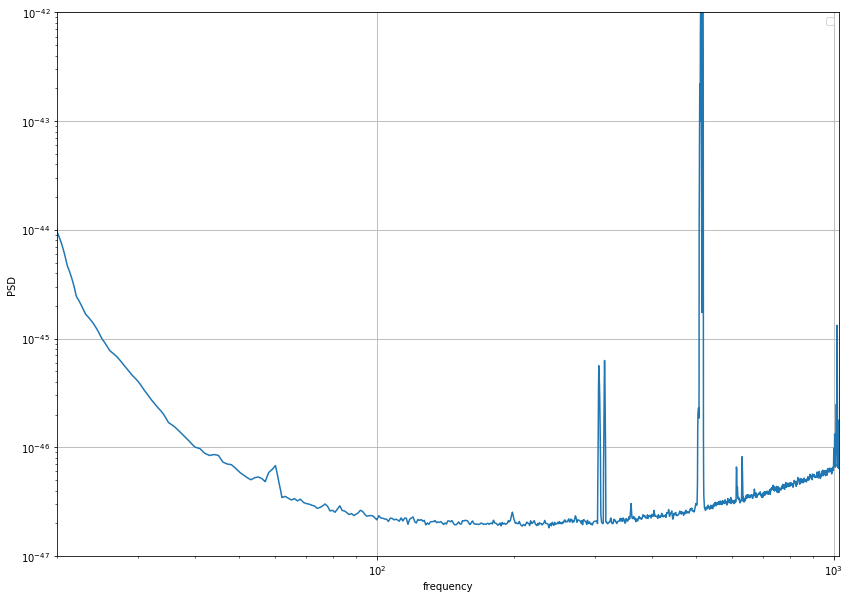

In [4]:
'''
Estimating the power spectral density of the given data
'''
from pycbc.psd import welch, interpolate
psds = interpolate(welch(d), 1.0 / d.duration)


pylab.figure(figsize=(14,10))

pylab.loglog(psds.sample_frequencies, psds)
pylab.ylabel('PSD')
pylab.xlabel('frequency')
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)
pylab.grid()
pylab.legend()

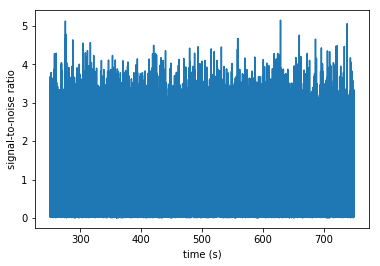

In [5]:
'''
For this test, one can chose set of template waveforms and compute SNR time series. 
For this case, I chose only the gravitational waveform temaple by chosing m1 = m2 = 10M_odot
'''

import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform
import pylab
flow = 30 #Hz
stilde = data.to_frequencyseries()


hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                             mass1=10, mass2=10,
                             f_lower=flow, delta_f=stilde.delta_f)

hp.resize(len(stilde))  
snr = pycbc.filter.matched_filter(hp, stilde, psd=psds,
                                      low_frequency_cutoff=flow)


# Remove regions corrupted by filter wraparound
snr = snr[len(snr) // 4: len(snr) * 3 // 4]

pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()

Comment : So, we see that maximum Signal to noise ratio is not crossing the thresold value(= 8), hence we can conclude this
    time seris contains no significant signal. 
    

In [6]:
'''
Problem 2: Part 2
'''

'\nProblem 2: Part 2\n'

In [7]:
'''Whiten the above data using its noise PSD. You can use PyCBC based function of the Welch method to estimate the PSD. Construct a histogram of the whitened data and show that the whiten data follows a Gaussian distribution with zero mean.
'''

'Whiten the above data using its noise PSD. You can use PyCBC based function of the Welch method to estimate the PSD. Construct a histogram of the whitened data and show that the whiten data follows a Gaussian distribution with zero mean.\n'

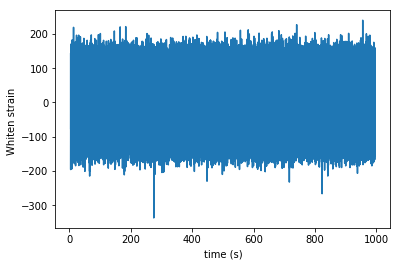

In [8]:
#Whitening the data

from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab

white_strain = (data.to_frequencyseries() / psds ** 0.5).to_timeseries()
white_strain = white_strain.crop(4, 4)

pylab.plot(white_strain.sample_times, white_strain)
pylab.ylabel('Whiten strain ')
pylab.xlabel('time (s)')
pylab.show()

/home/ayatri.singha/src/pycbc/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ayatri.singha/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  del sys.path[0]


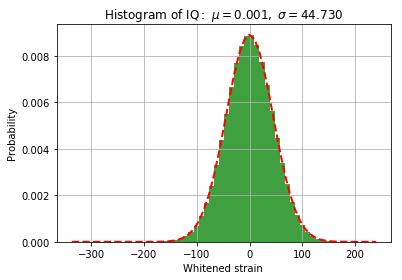

In [9]:
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

datos = white_strain
# best fit of data
(mu, sigma) = norm.fit(datos)

# the histogram of the data
n, bins, patches = plt.hist(datos, 60, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('Whitened strain ')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()

Commemts:Hence, we can see that the noise follows the Gaussian distribution. 

In [10]:

'''In gravitational wave data analysis, we consider that the noise is stationary Gaussian. But in reality, the stationary assumption does not hold. Can you think of a test to show that the stationarity does not hold?

'''

'In gravitational wave data analysis, we consider that the noise is stationary Gaussian. But in reality, the stationary assumption does not hold. Can you think of a test to show that the stationarity does not hold?\n\n'

In [13]:
SNR_list = []
Data = d

from pycbc.waveform import get_fd_waveform


hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=3,
                         mass2=3,
                         delta_f=1.0/(200.0) ,
                         distance = 500, 
                         f_lower=20.0, f_final = 2048.0)    #d = 4000 Mpc


segments = 200



for i in range(segments- 1):
    delta = Data.delta_t
    tseries = Data[int(i/delta) : int((i+1)/delta)]

    delta_t = 4*tseries.delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)

    psds  = pycbc.psd.interpolate(pycbc.psd.welch(tseries), hp.delta_f)
    
    #SNR_int = (hp/psds**0.5)*np.conj(hp/psds**0.5)
    SNR1 = (np.sum((4*hp*np.conj(hp)*hp.delta_f/psds).data).real)**0.5
    SNR_list.append( SNR1)
    
SNR_list = np.array(SNR_list)


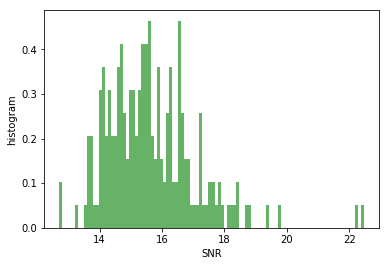

In [14]:
SNR_list =np.array(SNR_list)
# Plot the histogram.
plt.hist(SNR_list, bins=100, density=True, alpha=0.6, color='g')

plt.xlabel('SNR')
plt.ylabel('histogram')

plt.show()

Comment: We can see that the SNR of tha same waveform is different when we consider different chunks of data. Hence, we can see the noise in the real detector is not completely stationary. 